In [22]:
import numpy as np
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
import euclidemu2 as ee2

# --- Initialize emulator ---
emulator = CosmoPowerJAX(probe="mpk_lin")

# --- Load k-grid ---
k_full = emulator.modes.astype(np.float32)
k_idx = np.where((k_full > 1e-1) & (k_full < 4.9))[0]
k = k_full[k_idx]
print (np.shape(k_idx))


# --- Random cosmology ---
rng = np.random.default_rng(seed=42)
As = rng.uniform(1.7e-9, 2.5e-9)
ns = rng.uniform(0.92, 1.00)
Omb = rng.uniform(0.04, 0.06)
Omm = rng.uniform(0.24, 0.40)
h = rng.uniform(0.61, 0.73)
mnu = 0.0
w = -1.0
wa = 0.0

cosmo_dict = {
    'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h,
    'mnu': mnu, 'w': w, 'wa': wa,
}

print(cosmo_dict)

# --- Setup emulator inputs ---
omega_b = Omb * h**2
omega_cdm = (Omm - Omb) * h**2
ln_10_A_s = np.log(1e10 * As)



def get_nonlinear_pk(z):
    inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
    pk_lin = emulator.predict(inp)[k_idx]
    _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k)
    pk_nl = pk_lin * boost[0]
    return pk_nl

# --- Compute nonlinear P(k) ---
pk_nl_z5 = get_nonlinear_pk(5.0)
pk_nl_z45 = get_nonlinear_pk(4.5)
pk_nl_z0 = get_nonlinear_pk(0.0)

# --- Print example values ---
print("Nonlinear P(k) at z = 5:", pk_nl_z5[:5])
print("Nonlinear P(k) at z = 0:", pk_nl_z0[:5])




(182,)
{'As': 2.319164838844771e-09, 'ns': 0.9551102751801642, 'Omb': 0.05717195839822765, 'Omm': 0.35157888464949827, 'h': 0.6213012817465179, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
Nonlinear P(k) at z = 5: [476.18    451.06058 428.3976  408.7865  392.3688 ]
Nonlinear P(k) at z = 0: [11507.707 10939.883 10379.689  9879.999  9470.36 ]


In [23]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
import os
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX
import euclidemu2 as ee2

# --- Load k and emulator ---
emulator = CosmoPowerJAX(probe="mpk_lin")
k_full = emulator.modes.astype(np.float32)
k_idx = np.where((k_full > 1e-1) & (k_full < 4.9))[0]
k = k_full[k_idx]
k_shp = np.shape(k_idx)[0]

# --- Random cosmology ---
rng = np.random.default_rng(42)
As = rng.uniform(1.7e-9, 2.5e-9)
ns = rng.uniform(0.92, 1.00)
Omb = rng.uniform(0.04, 0.06)
Omm = rng.uniform(0.24, 0.40)
h = rng.uniform(0.61, 0.73)

cosmo_dict = {'As': As, 'ns': ns, 'Omb': Omb, 'Omm': Omm, 'h': h, 'mnu': 0.0, 'w': -1.0, 'wa': 0.0}
omega_b = Omb * h**2
omega_cdm = (Omm - Omb) * h**2
ln_10_A_s = np.log(1e10 * As)

# --- Get nonlinear logP(k,z) ---
def get_nl_logpk(z):
    inp = np.array([omega_b, omega_cdm, h, ns, ln_10_A_s, z], dtype=np.float32)
    pk_lin = emulator.predict(inp)[k_idx]
    _, boost = ee2.get_boost(cosmo_dict, np.array([z]), k)
    pk_nl = pk_lin * boost[0]
    return jnp.log(pk_nl.astype(jnp.float32))

# --- Background quantities ---
G = 4.30091e-9  # Mpc Msun^-1 (km/s)^2

def Hz_func(z):
    a = 1.0 / (1.0 + z)
    Ez2 = Omm * (1 + z)**3 + (1 - Omm) * a**(-3 * (1 + (-1.0)))
    return 100.0 * h * jnp.sqrt(Ez2)

def rho_m_func(z):
    Hz = Hz_func(z)
    rho_crit = 3 * Hz**2 / (8 * jnp.pi * G)
    return Omm * rho_crit

# --- Load normalization ---
data_dir = "/srv/scratch3/taylor.4264/odd_emu/production_run_logpk/merged/"
Hz_all = np.load(os.path.join(data_dir, "Hz.npy"))
rho_m_all = np.load(os.path.join(data_dir, "rho_m.npy"))

H_mean, H_std = Hz_all.mean(), Hz_all.std()
log_rho_all = np.log10(rho_m_all + 1e-30)
log_rho_mean, log_rho_std = log_rho_all.mean(), log_rho_all.std()

def H_norm(z):
    return (Hz_func(z) - H_mean) / H_std

def rho_norm(z):
    return (jnp.log10(rho_m_func(z) + 1e-30) - log_rho_mean) / log_rho_std

# --- Define model class ---
class RHS(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key=None):
        dummy_key = jax.random.PRNGKey(0) if key is None else key
        self.mlp = eqx.nn.MLP(in_size=k_shp + 3, out_size=k_shp, width_size=512, depth=4, key=dummy_key)

    def __call__(self, P, H, rho, z):
        x = jnp.concatenate([P, H, rho, jnp.atleast_1d(z)])
        return self.mlp(x)

# --- ODE RHS ---
def rhs(z, logP, args):
    model, = args
    H_z = jnp.atleast_1d(H_norm(z))
    rho_z = jnp.atleast_1d(rho_norm(z))
    return model(logP, H_z, rho_z, z)

# --- Initial condition and time range ---
z0 = 5.0
z1 = 0.0
ts = jnp.linspace(z0, z1, 100)
logpk0 = get_nl_logpk(z0)

# --- Solve with all 10 models ---
model_dir = "/srv/scratch3/taylor.4264/odd_emu/models_final"
all_pk = []

for i in range(1):
    model_path = os.path.join(model_dir, f"learned_model_logpk_{i}.eqx")
    model = RHS()
    model_params = eqx.tree_deserialise_leaves(model_path, model)
    model = eqx.combine(model_params, model)

    term = ODETerm(rhs)
    solver = Tsit5()
    saveat = SaveAt(ts=ts)

    sol = diffeqsolve(
        term,
        solver,
        t0=z0,
        t1=z1,
        dt0=-1e-2,
        y0=logpk0,
        args=(model,),
        saveat=saveat
    )
    logpk_sol = sol.ys
    all_pk.append(jnp.exp(logpk_sol))

# --- Average prediction over models ---
pk_mean = jnp.mean(jnp.stack(all_pk), axis=0)

print(f"Averaged nonlinear P(k) shape: {pk_mean.shape}")
print(f"P(k, z=5): {pk_mean[0, :5]}")
print(f"P(k, z=0): {pk_mean[-1, :5]}")

Averaged nonlinear P(k) shape: (100, 182)
P(k, z=5): [476.17993 451.06067 428.39767 408.78656 392.36884]
P(k, z=0): [12573.52  11832.529 11381.12  10437.721  9922.616]


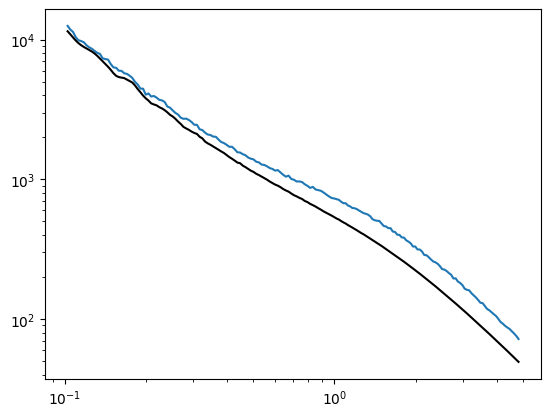

In [20]:
from matplotlib import pyplot as plt
plt.plot(k,pk_mean[-1])
plt.plot(k,pk_nl_z0, color = 'k')
plt.xscale('log')
plt.yscale('log')

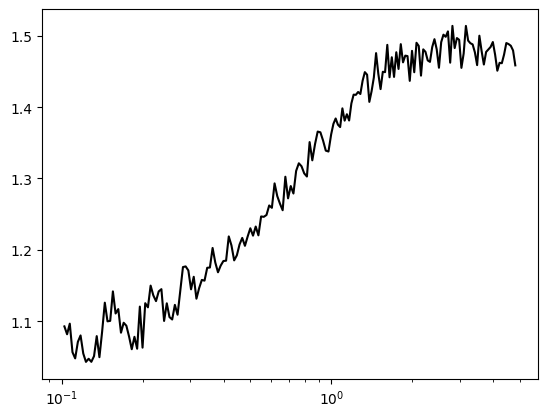

In [21]:
plt.plot(k,pk_mean[-1]/ pk_nl_z0, color = 'k')
#plt.plot(k,all_pk[0][-1]/ pk_nl_z0)
#plt.plot(k,all_pk[1][-1]/ pk_nl_z0)
#plt.plot(k,all_pk[3][-1]/ pk_nl_z0)
#plt.plot(k,all_pk[5][-1]/ pk_nl_z0)
plt.xscale('log')